In [7]:
# ============================================================
# Final Project: Train neural net on MNIST and evaluate on local digits
# ============================================================

import os
import glob
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------------------------
# Device
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


Trainloader loaded: 844
Valloader loaded: 94


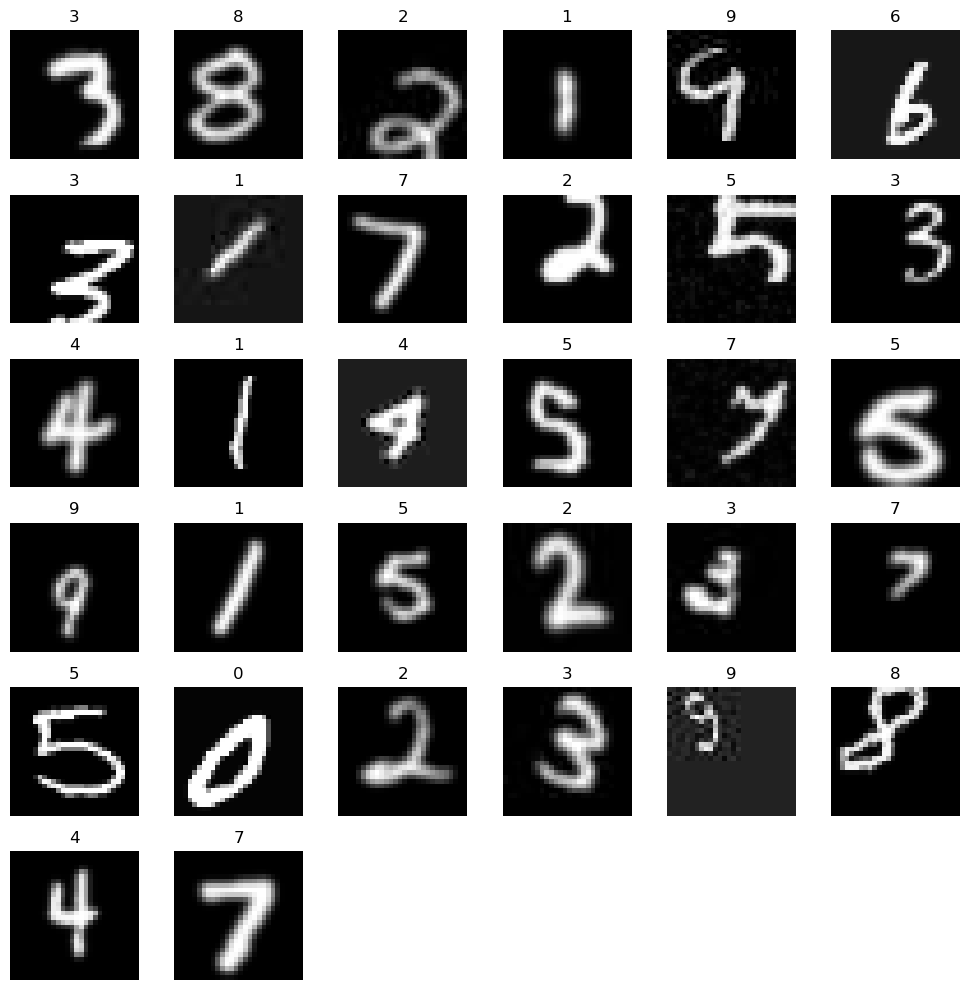

In [8]:

# ============================================================
# 1. Data and augmentation setup
# ============================================================


class RaiseDarkPoint(object):
    def __init__(self, grayRange=(10, 60)):
        self.grayRange = grayRange

    def __call__(self, img):
        arr = np.array(img).astype(np.float32)
        grayVal = np.random.uniform(*self.grayRange)
        mask = arr < 30
        arr[mask] = arr[mask] + grayVal
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8), mode="L")


class LowerWhitePoint(object):
    def __init__(self, factorRange=(0.7, 0.95)):
        self.factorRange = factorRange

    def __call__(self, img):
        arr = np.array(img, dtype=np.float32)
        factor = float(np.random.uniform(self.factorRange[0], self.factorRange[1]))
        arr = arr * factor
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8), mode="L")


class AddNoise(object):
    def __init__(self, noiseStd=0.05):
        self.noiseStd = noiseStd

    def __call__(self, img):
        arr = np.array(img).astype(np.float32)
        noise = np.random.normal(0, self.noiseStd * 255, arr.shape)
        arr = arr + noise
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8), mode="L")


class BubblyDigits(object):
    def __init__(self, blurRange=(0.4, 1.0), contrastRange=(1.1, 1.6)):
        self.blurRange = blurRange
        self.contrastRange = contrastRange

    def __call__(self, img):
        sigma = float(np.random.uniform(self.blurRange[0], self.blurRange[1]))
        img = img.filter(ImageFilter.GaussianBlur(radius=sigma))
        c = float(np.random.uniform(self.contrastRange[0], self.contrastRange[1]))
        img = ImageEnhance.Contrast(img).enhance(c)
        return img


class JPEGCompression(object):
    def __init__(self, qualityRange=(40, 80)):
        self.qualityRange = qualityRange

    def __call__(self, img):
        q = int(np.random.randint(self.qualityRange[0], self.qualityRange[1]))
        buf = BytesIO()
        img.save(buf, format="JPEG", quality=q)
        buf.seek(0)
        return Image.open(buf).convert("L")


trainTransform = transforms.Compose(
    [
        transforms.RandomApply(
            [
                transforms.Pad(4, fill=0),
                transforms.RandomCrop(28),
            ],
            p=0.5,
        ),
        transforms.RandomApply(
            [
                transforms.RandomAffine(
                    degrees=(-5, 20),
                    translate=(0.25, 0.25),
                    scale=(0.6, 1.1),
                    fill=0,
                )
            ],
            p=0.5,
        ),
        transforms.RandomApply([AddNoise()], p=0.1),
        transforms.RandomApply([BubblyDigits()], p=0.5),
        transforms.RandomApply([LowerWhitePoint()], p=0.4),
        transforms.RandomApply([RaiseDarkPoint()], p=0.4),
        transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5))], p=1
        ),
        transforms.RandomApply([JPEGCompression()], p=0.25),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


def PreprocessSingle(image):
    if image.mode != "RGB":
        image = image.convert("RGB")

    blurred = image.filter(ImageFilter.GaussianBlur(radius=0.75))
    arr = np.array(blurred).astype(np.float32)
    gray = arr.mean(axis=2)

    minVal = gray.min()
    maxVal = gray.max()

    if maxVal - minVal < 1e-6:
        stretched = np.zeros_like(gray)
    else:
        stretched = (gray - minVal) / (maxVal - minVal) * 255.0

    stretched = stretched.astype(np.uint8)
    return Image.fromarray(stretched, mode="L")


# -----------------------------
# MNIST train/val/test split
# -----------------------------
fullTrainAug = datasets.MNIST(
    "~/.pytorch/MNIST_data/", download=True, train=True, transform=trainTransform
)
fullTrainPlain = datasets.MNIST(
    "~/.pytorch/MNIST_data/", download=True, train=True, transform=transform
)

trainSize = int(0.9 * len(fullTrainAug))
valSize = len(fullTrainAug) - trainSize

indices = torch.randperm(len(fullTrainAug)).tolist()
trainIdx = indices[:trainSize]
valIdx = indices[trainSize:]

trainSet = Subset(fullTrainAug, trainIdx)   # with augmentation
valSet = Subset(fullTrainPlain, valIdx)     # no augmentation

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=64, shuffle=True)
valLoader = torch.utils.data.DataLoader(valSet, batch_size=64, shuffle=False)

testSet = datasets.MNIST(
    "~/.pytorch/MNIST_data/", download=True, train=False, transform=transform
)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False)

print("Trainloader loaded:", len(trainLoader))
print("Valloader loaded:", len(valLoader))

dataIter = iter(trainLoader)
imgs, labels = next(dataIter)
imgsVis = imgs * 0.5 + 0.5

plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(6, 6, i + 1)
    plt.imshow(imgsVis[i].squeeze().cpu(), cmap="gray")
    plt.title(labels[i].item())
    plt.axis("off")
plt.tight_layout()
plt.show(block=False)
plt.pause(0.001)




In [9]:
# ============================================================
# 2. Model definition
# ============================================================


class MNISTMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x


model = MNISTMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=5,
)

print(model)


MNISTMLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


Epoch 1/100, Train Loss: 1.2849, Val Loss: 0.2852 Learning Rate: 0.000500
Epoch 2/100, Train Loss: 0.8765, Val Loss: 0.1568 Learning Rate: 0.000500
Epoch 3/100, Train Loss: 0.7665, Val Loss: 0.1481 Learning Rate: 0.000500
Epoch 4/100, Train Loss: 0.6905, Val Loss: 0.1647 Learning Rate: 0.000500
Epoch 5/100, Train Loss: 0.6503, Val Loss: 0.1482 Learning Rate: 0.000500
Epoch 6/100, Train Loss: 0.6108, Val Loss: 0.1119 Learning Rate: 0.000500
Epoch 7/100, Train Loss: 0.5815, Val Loss: 0.1175 Learning Rate: 0.000500
Epoch 8/100, Train Loss: 0.5666, Val Loss: 0.0931 Learning Rate: 0.000500
Epoch 9/100, Train Loss: 0.5401, Val Loss: 0.0890 Learning Rate: 0.000500
Epoch 10/100, Train Loss: 0.5263, Val Loss: 0.0795 Learning Rate: 0.000500
Epoch 11/100, Train Loss: 0.5188, Val Loss: 0.0944 Learning Rate: 0.000500
Epoch 12/100, Train Loss: 0.5068, Val Loss: 0.0898 Learning Rate: 0.000500
Epoch 13/100, Train Loss: 0.4920, Val Loss: 0.0941 Learning Rate: 0.000500
Epoch 14/100, Train Loss: 0.4857, 

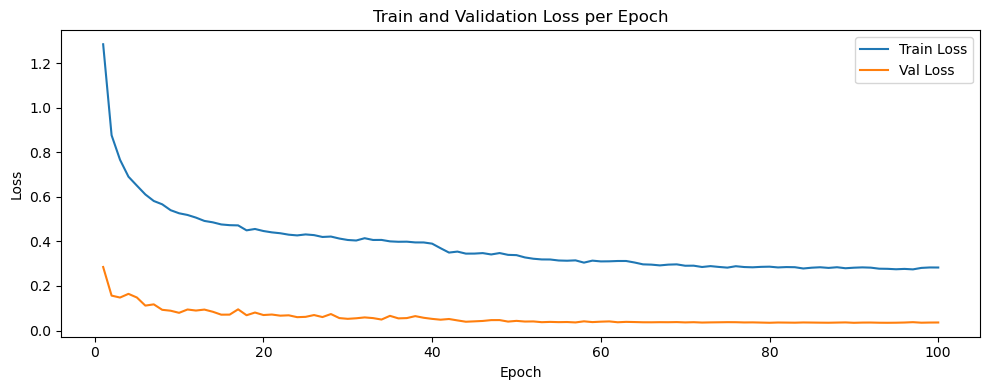

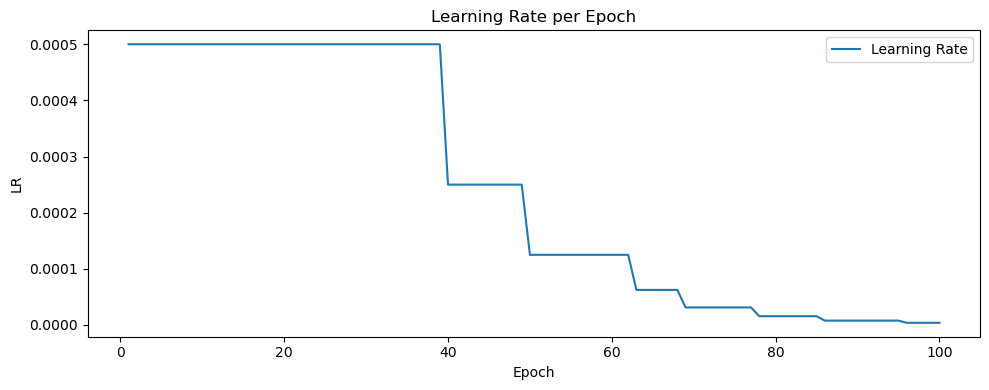

In [10]:
# ============================================================
# 3. Training + validation loop
# ============================================================

numEpochs = 100
epochTrainLosses = []
valLosses = []
learningRates = []

for epoch in range(numEpochs):
    model.train()
    runningLoss = 0.0

    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        runningLoss += loss.item()

    epochLoss = runningLoss / len(trainLoader)
    epochTrainLosses.append(epochLoss)

    # ---- validation loss (no gradient, no augmentation) ----
    model.eval()
    valRunningLoss = 0.0
    with torch.no_grad():
        for images, labels in valLoader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            valRunningLoss += loss.item()

    valLoss = valRunningLoss / len(valLoader)
    valLosses.append(valLoss)

    # Step scheduler on validation loss, then read scalar LR
    scheduler.step(valLoss)
    currentLr = optimizer.param_groups[0]["lr"]
    learningRates.append(currentLr)

    print(
        f"Epoch {epoch+1}/{numEpochs}, "
        f"Train Loss: {epochLoss:.4f}, Val Loss: {valLoss:.4f} "
        f"Learning Rate: {currentLr:.6f}"
    )

print("Training complete.")

epochs = range(1, numEpochs + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs, epochTrainLosses, label="Train Loss")
plt.plot(epochs, valLosses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss per Epoch")
plt.legend()
plt.tight_layout()
plt.show(block=False)
plt.pause(0.001)


# Learning rate per epoch
plt.figure(figsize=(10, 4))
plt.plot(epochs, learningRates, label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning Rate per Epoch")
plt.legend()
plt.tight_layout()
plt.show(block=False)
plt.pause(0.001)



In [11]:
# ============================================================
# 4. Evaluation helpers
# ============================================================


def EvaluateWithDetails(loader, name="Dataset"):
    model.eval()
    allPreds, allLabels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            _, preds = torch.max(logits, 1)
            allPreds.extend(preds.cpu().numpy())
            allLabels.extend(labels.cpu().numpy())

    allPreds = np.array(allPreds)
    allLabels = np.array(allLabels)

    accuracy = (allPreds == allLabels).mean()
    errorRate = 1.0 - accuracy

    print(f"\n==== {name} RESULTS ====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {errorRate:.4f}")

    print("\nClassification Report:")
    print(classification_report(allLabels, allPreds, digits=4))

    print("Confusion Matrix:")
    print(confusion_matrix(allLabels, allPreds))

    return accuracy


mnistAcc = EvaluateWithDetails(testLoader, "MNIST Test Set")
print("MNIST test accuracy (float):", float(mnistAcc))



==== MNIST Test Set RESULTS ====
Accuracy: 0.9910
Error Rate: 0.0090

Classification Report:
              precision    recall  f1-score   support

           0     0.9959    0.9949    0.9954       980
           1     0.9895    0.9965    0.9930      1135
           2     0.9922    0.9893    0.9908      1032
           3     0.9911    0.9891    0.9901      1010
           4     0.9899    0.9939    0.9919       982
           5     0.9911    0.9955    0.9933       892
           6     0.9927    0.9906    0.9916       958
           7     0.9808    0.9922    0.9865      1028
           8     1.0000    0.9836    0.9917       974
           9     0.9881    0.9841    0.9861      1009

    accuracy                         0.9910     10000
   macro avg     0.9911    0.9910    0.9910     10000
weighted avg     0.9910    0.9910    0.9910     10000

Confusion Matrix:
[[ 975    0    1    0    0    1    2    1    0    0]
 [   0 1131    0    0    0    0    1    3    0    0]
 [   1    1 1021    3  

In [12]:
# ============================================================
# 5. Local handwritten digit dataset
# ============================================================


class HandwrittenDigits(Dataset):
    def __init__(self, root, transform=None):
        self.paths = sorted(glob.glob(os.path.join(root, "*.png")))
        self.transform = transform
        self.labels = [int(os.path.basename(p).split("-")[0]) for p in self.paths]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx])
        img = PreprocessSingle(img)
        img = img.resize((28, 28))
        if self.transform is not None:
            img = self.transform(img)
        return img, self.labels[idx]


digitsRoot = "./digits"
handSet = HandwrittenDigits(digitsRoot, transform)

handLoader = torch.utils.data.DataLoader(handSet, batch_size=64, shuffle=False)

print("Handwritten digits found:", len(handSet))

if len(handSet) > 0:
    EvaluateWithDetails(handLoader, "Handwritten Digits")
else:
    print("No handwritten digits found.")

torch.save(model.state_dict(), "model.pth")


Handwritten digits found: 330

==== Handwritten Digits RESULTS ====
Accuracy: 0.9515
Error Rate: 0.0485

Classification Report:
              precision    recall  f1-score   support

           0     0.9706    1.0000    0.9851        33
           1     0.9697    0.9697    0.9697        33
           2     0.8649    0.9697    0.9143        33
           3     0.9667    0.8788    0.9206        33
           4     1.0000    0.9697    0.9846        33
           5     0.8571    0.9091    0.8824        33
           6     0.9412    0.9697    0.9552        33
           7     1.0000    1.0000    1.0000        33
           8     1.0000    0.8788    0.9355        33
           9     0.9697    0.9697    0.9697        33

    accuracy                         0.9515       330
   macro avg     0.9540    0.9515    0.9517       330
weighted avg     0.9540    0.9515    0.9517       330

Confusion Matrix:
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 32  1  0  0  0  0  0  0  0]
 [ 0  1 32  0  0  0  0  0  0 